In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2025s2-iud-pre-processed-data/final_dataset.csv


In [2]:
# STEP 1 — Load & clean
import pandas as pd
import numpy as np

# 1) Read
FILE = "/kaggle/input/2025s2-iud-pre-processed-data/final_dataset.csv"
df = pd.read_csv(FILE)

# 2) Standardize column names (no spaces) for easier modeling
rename_map = {
    "Maximum temperature (Degree C)": "MaxTemp",
    "Minimum temperature (Degree C)": "MinTemp",
    "Rainfall amount (millimetres)": "Rainfall",
}
df = df.rename(columns=rename_map)

# 3) Coerce dtypes
df["Year"] = df["Year"].astype(int)
df["SkiWeek"] = df["SkiWeek"].astype(int)
df["Resort"] = df["Resort"].astype("category")
for c in ["Visitors","MaxTemp","MinTemp","Rainfall"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 4) Basic cleaning: drop bad rows, keep logical order
df = df.dropna(subset=["Visitors","MaxTemp","MinTemp","Rainfall"])
df = df[df["Visitors"] > 0]            # (you said you want to drop 0-visitor weeks)
df = df.sort_values(["Resort","Year","SkiWeek"]).reset_index(drop=True)

# 5) Quick sanity checks
print(df.dtypes, "\n")
print("Rows:", len(df))
print("Years:", df["Year"].min(), "→", df["Year"].max())
print("\nTop resorts by count:")
print(df.groupby("Resort").size().sort_values(ascending=False).head())

# Peek at the last rows
df.tail(10)


Year           int64
SkiWeek        int64
Resort      category
Visitors       int64
MaxTemp      float64
MinTemp      float64
Rainfall     float64
dtype: object 

Rows: 1267
Years: 2014 → 2024

Top resorts by count:
Resort
Charlotte Pass    160
Falls Creek       160
Selwyn            160
Perisher          160
Thredbo           160
dtype: int64


/tmp/ipykernel_19/2630613252.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("Resort").size().sort_values(ascending=False).head())


,Year,SkiWeek,Resort,Visitors,MaxTemp,MinTemp,Rainfall
1257,2024,6,Thredbo,48866,-1.628571,-5.285714,16.4
1258,2024,7,Thredbo,46149,0.671429,-4.157143,24.4
1259,2024,8,Thredbo,43752,-0.057143,-7.542857,4.6
1260,2024,9,Thredbo,46790,2.342857,-4.371429,0.0
1261,2024,10,Thredbo,41927,4.328571,-0.842857,17.6
1262,2024,11,Thredbo,37608,3.500000,-0.700000,29.8
1263,2024,12,Thredbo,33208,2.500000,-1.171429,69.4
1264,2024,13,Thredbo,18120,4.614286,-0.700000,23.6
1265,2024,14,Thredbo,6270,5.857143,-1.242857,11.4
1266,2024,15,Thredbo,4103,0.871429,-4.257143,16.0


In [3]:
# STEP 2 — Features and time split

from sklearn.model_selection import train_test_split

# 1) One-hot encode resort
df_ml = pd.get_dummies(df, columns=["Resort"], drop_first=True)

# 2) Define features and targets
X = df_ml.drop(columns=["Visitors","MaxTemp","MinTemp","Rainfall"])
y = df_ml[["Visitors","MaxTemp","MinTemp","Rainfall"]]

# 3) Train/test split by year
train = df_ml[df_ml["Year"] <= 2022]
test  = df_ml[df_ml["Year"] > 2022]

X_train = train.drop(columns=["Visitors","MaxTemp","MinTemp","Rainfall"])
y_train = train[["Visitors","MaxTemp","MinTemp","Rainfall"]]

X_test = test.drop(columns=["Visitors","MaxTemp","MinTemp","Rainfall"])
y_test = test[["Visitors","MaxTemp","MinTemp","Rainfall"]]

print("Train years:", train["Year"].min(), "→", train["Year"].max())
print("Test years:", test["Year"].min(), "→", test["Year"].max())
print("X_train:", X_train.shape, " | y_train:", y_train.shape)
print("X_test :", X_test.shape, " | y_test :", y_test.shape)

Train years: 2014 → 2022
Test years: 2023 → 2024
X_train: (1034, 9)  | y_train: (1034, 4)
X_test : (233, 9)  | y_test : (233, 4)


In [4]:
# STEP 3 — Multi-output Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1) Define model
base_model = RandomForestRegressor(
    n_estimators=300,       # more trees = stronger model
    max_depth=None,         # let it grow fully
    random_state=42,
    n_jobs=-1
)

model = MultiOutputRegressor(base_model)

# 2) Fit
model.fit(X_train, y_train)

# 3) Predict
y_pred = model.predict(X_test)

# 4) Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput="raw_values"))
r2 = r2_score(y_test, y_pred, multioutput="raw_values")

for i, col in enumerate(y_train.columns):
    print(f"{col:10s} | RMSE={rmse[i]:.3f} | R2={r2[i]:.3f}")

Visitors   | RMSE=10741.254 | R2=0.672
MaxTemp    | RMSE=2.682 | R2=0.139
MinTemp    | RMSE=2.254 | R2=0.091
Rainfall   | RMSE=41.458 | R2=-1.481


In [5]:
# STEP 4 — Predict for test set and export

# Predict on test set
y_pred = model.predict(X_test)

# Make DataFrame
pred_df = test[["Year","SkiWeek"]]  # keep identifiers
pred_df["Resort"] = df.loc[test.index, "Resort"].values  # map back resort names

# Add predictions
pred_df["Pred_Visitors"] = y_pred[:,0].round().astype(int)
pred_df["Pred_MaxTemp"]  = y_pred[:,1].round(2)
pred_df["Pred_MinTemp"]  = y_pred[:,2].round(2)
pred_df["Pred_Rainfall"] = y_pred[:,3].round(1)

# Optionally include true values for comparison
for col in ["Visitors","MaxTemp","MinTemp","Rainfall"]:
    pred_df[f"True_{col}"] = y_test[col].values

# Save to CSV
output_file = "predictions.csv"
pred_df.to_csv(output_file, index=False)

print("✅ Predictions saved to", output_file)
pred_df.head(10)

✅ Predictions saved to predictions.csv


/tmp/ipykernel_19/3642083768.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df["Resort"] = df.loc[test.index, "Resort"].values  # map back resort names
/tmp/ipykernel_19/3642083768.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df["Pred_Visitors"] = y_pred[:,0].round().astype(int)
/tmp/ipykernel_19/3642083768.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,Year,SkiWeek,Resort,Pred_Visitors,Pred_MaxTemp,Pred_MinTemp,Pred_Rainfall,True_Visitors,True_MaxTemp,True_MinTemp,True_Rainfall
130,2023,1,Charlotte Pass,3026,0.75,-4.33,11.8,605,1.928571,-2.642857,75.0
131,2023,2,Charlotte Pass,2675,2.69,-3.30,38.8,741,0.550000,-4.057143,17.2
132,2023,3,Charlotte Pass,3000,2.37,-3.12,24.4,1607,-0.692857,-3.628571,70.1
133,2023,4,Charlotte Pass,4668,2.15,-3.79,7.4,3258,2.635714,-2.585714,25.2
134,2023,5,Charlotte Pass,4304,0.53,-5.30,6.2,3688,1.842857,-2.221429,45.7
135,2023,6,Charlotte Pass,3893,0.09,-6.52,31.5,3573,4.178571,-3.000000,1.7
136,2023,7,Charlotte Pass,3760,2.45,-3.15,28.8,3165,4.357143,-4.371429,2.4
137,2023,8,Charlotte Pass,3600,1.59,-4.05,59.2,3090,4.564286,-0.435714,30.1
138,2023,9,Charlotte Pass,3511,1.53,-3.98,118.5,2884,5.585714,-2.085714,34.0
139,2023,10,Charlotte Pass,3598,1.57,-2.98,62.0,2901,2.542857,-4.535714,8.7


In [6]:
# STEP 5 — Predict 2026 for all resorts × ski weeks

# 1) Extract unique resorts and weeks
resorts = df["Resort"].unique()
weeks = sorted(df["SkiWeek"].unique())

# 2) Build 2026 dataframe (cartesian product)
future = pd.DataFrame([
    {"Year": 2026, "SkiWeek": w, "Resort": r}
    for r in resorts for w in weeks
])

# 3) One-hot encode with same columns as training
future_ml = pd.get_dummies(future, columns=["Resort"], drop_first=True)

# Ensure same feature set as X_train
for col in X_train.columns:
    if col not in future_ml.columns:
        future_ml[col] = 0
future_ml = future_ml[X_train.columns]  # align order

# 4) Predict
future_pred = model.predict(future_ml)

# 5) Build final output
future_out = future.copy()
future_out["Pred_Visitors"] = future_pred[:,0].round().astype(int)
future_out["Pred_MaxTemp"]  = future_pred[:,1].round(2)
future_out["Pred_MinTemp"]  = future_pred[:,2].round(2)
future_out["Pred_Rainfall"] = future_pred[:,3].round(1)

# 6) Save
future_out.to_csv("predictions_2026.csv", index=False)
print("✅ 2026 predictions saved to predictions_2026.csv")
future_out.head(30)

✅ 2026 predictions saved to predictions_2026.csv


,Year,SkiWeek,Resort,Pred_Visitors,Pred_MaxTemp,Pred_MinTemp,Pred_Rainfall
0,2026,1,Charlotte Pass,3026,0.75,-4.33,11.8
1,2026,2,Charlotte Pass,2675,2.69,-3.30,38.8
2,2026,3,Charlotte Pass,3000,2.37,-3.12,24.4
3,2026,4,Charlotte Pass,4668,2.15,-3.79,7.4
4,2026,5,Charlotte Pass,4304,0.53,-5.30,6.2
5,2026,6,Charlotte Pass,3893,0.09,-6.52,31.5
6,2026,7,Charlotte Pass,3760,2.45,-3.15,28.8
7,2026,8,Charlotte Pass,3600,1.59,-4.05,59.2
8,2026,9,Charlotte Pass,3511,1.53,-3.98,118.5
9,2026,10,Charlotte Pass,3598,1.57,-2.98,62.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

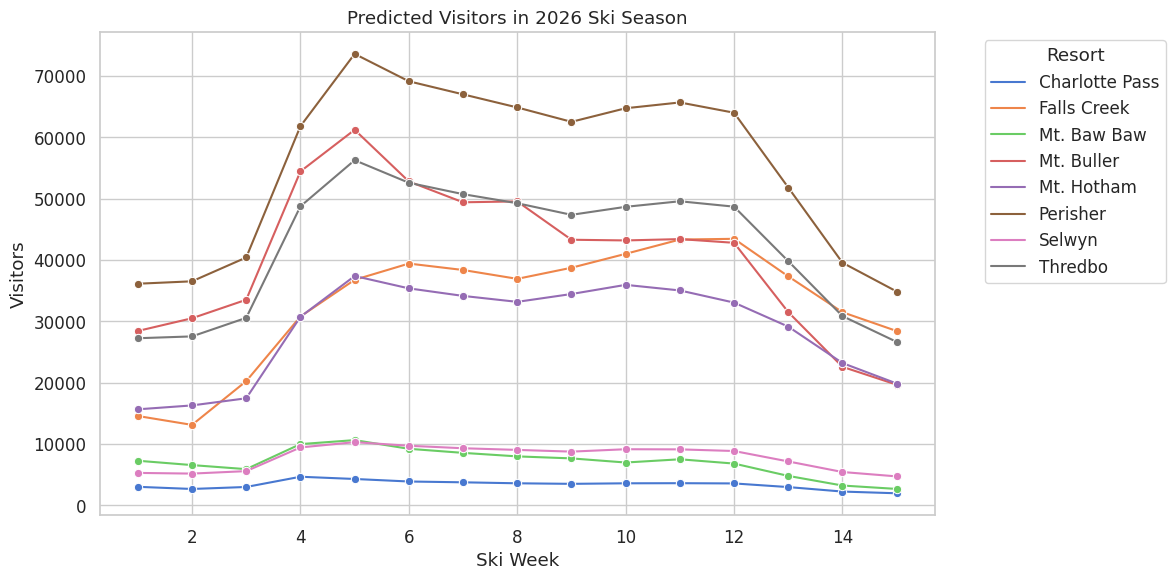

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

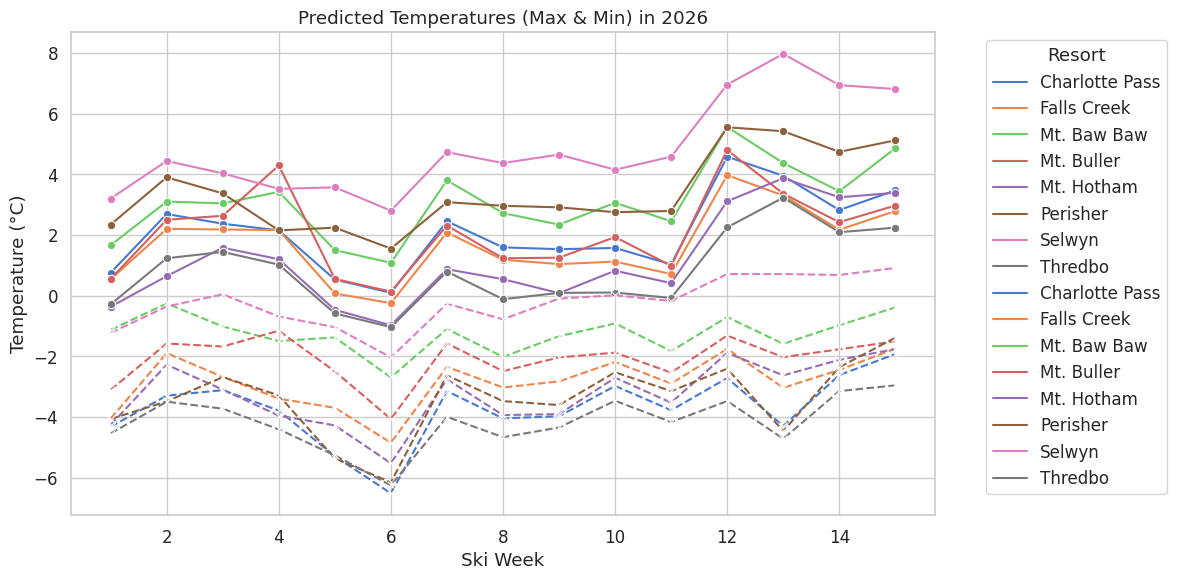

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

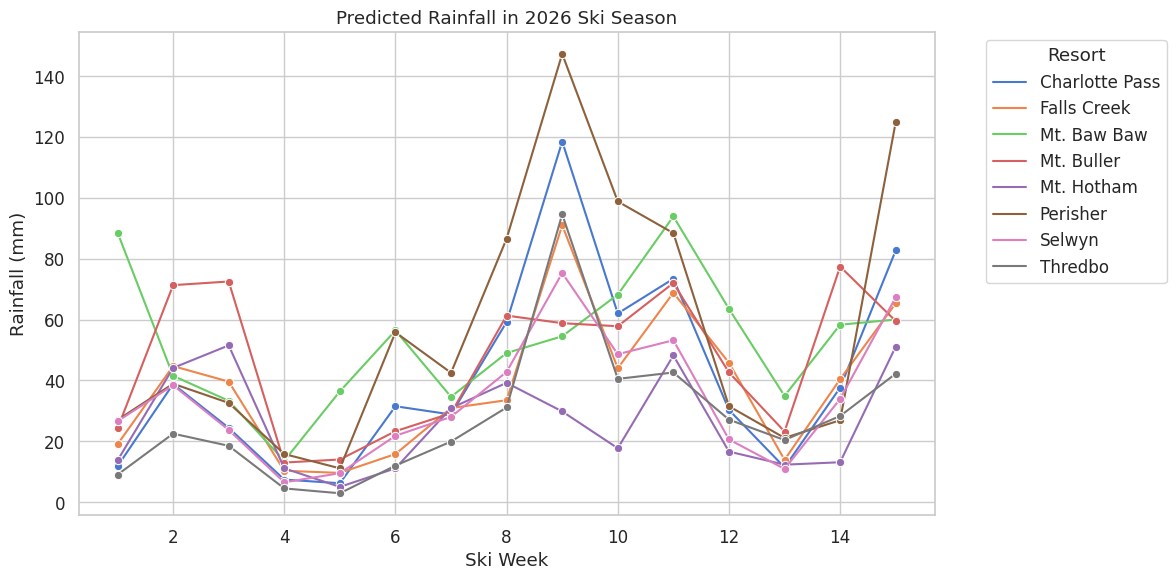

In [7]:
# STEP 6 — Visualize 2026 predictions
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 1) Visitors trend
plt.figure(figsize=(12,6))
sns.lineplot(
    data=future_out,
    x="SkiWeek", y="Pred_Visitors", hue="Resort", marker="o"
)
plt.title("Predicted Visitors in 2026 Ski Season")
plt.ylabel("Visitors")
plt.xlabel("Ski Week")
plt.legend(title="Resort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 2) Max/Min temperature
plt.figure(figsize=(12,6))
sns.lineplot(
    data=future_out,
    x="SkiWeek", y="Pred_MaxTemp", hue="Resort", marker="o"
)
sns.lineplot(
    data=future_out,
    x="SkiWeek", y="Pred_MinTemp", hue="Resort", marker="x", linestyle="--"
)
plt.title("Predicted Temperatures (Max & Min) in 2026")
plt.ylabel("Temperature (°C)")
plt.xlabel("Ski Week")
plt.legend(title="Resort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 3) Rainfall
plt.figure(figsize=(12,6))
sns.lineplot(
    data=future_out,
    x="SkiWeek", y="Pred_Rainfall", hue="Resort", marker="o"
)
plt.title("Predicted Rainfall in 2026 Ski Season")
plt.ylabel("Rainfall (mm)")
plt.xlabel("Ski Week")
plt.legend(title="Resort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()